<div align="center"><h1>Control Engineering with Python</h1>
<br><b>Dr.Varodom Toochinda</b>
<br>Dept. of Mechanical Engineering, Kasetsart University</div>

<a href="https://colab.research.google.com/github/dewdotninja/control_python/blob/master/lsid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Least Square System Identification

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    


In [ ]:
!pip install slycot

In [ ]:
!pip install control

This notebook is used as course 
material for Electrical-Mechanical Manufacturing Engineering (EMME), Department of Mechanical 
Engineering, Kasetsart University.

In [1]:
import control as ctl 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# check version of Python Control System Library. 
# This notebook is tested with version 0.9.0
ctl.__version__

'0.9.0'

In any model-based control design scheme, it is essential to first obtain a math model of the physical system, 
or the plant we want to control. The design then exploits that information in certain way to craft a controller 
for that particular plant, subjecting to user specifications or design constraints. So it is rational to say, 
regardless of any sophisticated design paradigm or software tool used, that a controller will be as good as the model 
that represents the actual plant.  

There are 2 basic approaches to achieve a math model of a physical system. The first relies on theory. One can start 
from physics; i.e., form an equation and substitute parameters, either from datasheet or measurement. 
The second approach uses data captured from the real plant and tries to identify the math model from such information. 
The latter is generally classified as system identification. 

For the first approach, a robot joint driven by DC motor presented in the Control Engineering Basic modules serves as 
a good example. This notebook focuses on practical system identification (SysID). Some examples from our past 
research are also discussed.

### Classification of SysID

A general concept of SysID can be depicted as in Figure 1. The real plant is treated like a black box. An input 
signal is applied to the plant and the resulting output measured. This input and output dataset is then processed 
by some kind of “matching” algorithm, in order to find a good estimate of math model for this plant. There is no 
immediate choice for the best identification algorithm, since this area is still an active research and there are 
varieties of them out there. One could use curve-fitting, least-square estimation, or even a neuro-fuzzy approach.
There are also online and offline versions. 

!["Fig 1"](https://drive.google.com/uc?id=1zE6Wkni6MRwGROtWTGFacD2MV9qCvrHN)

Figure 1 system identification process

Nevertheless, we can generally classify SysID into two groups, namely

1.	Non-parametric identification
2.	Parametric identification

Both will be discussed later. Before that we have something to say about appropriate input signals used in the 
identification process.

### Input Choices

Even though the concept of SysID sounds simple enough, the success depends significantly on proper selection of 
input signals. As an analogy, imagine a psychiatrist who wants to study a new patient. She can’t just walk in 
and chat with the subject irrelevantly. Instead, she needs to prepare a set of questions that are rich enough in 
content, or perhaps provocative, to obtain answers that contain insights or information that characterizes that 
patient. Likewise, the input used in SysID must be “persistently exciting,” i.e., rich enough to excite all dynamics 
of the plant. 

So, what kind of inputs is the best candidate? We could see this more clearly in the frequency domain. Consider a 
plant described by a transfer function $P(s)$. The input and output relationships can be written simply as

$$
y(s) = P(s)u(s) \tag{1}
$$

Let’s say we feed a sinusoid signal as input, what comes out is a complex number that represents only a single data point
in the Bode frequency response. An input with unit magnitude for all frequency, on the other hand, should render the 
output spectrum to match the plant frequency response exactly, as shown in Figure 2. In most cases, a good candidate 
for input must energize the system at least in the frequency range of interest. Ideally, we prefer an input with 
flat magnitude for the whole spectrum. Though it might not be possible to find such input in reality, there are 
input choices good enough for SysID. Below we list some of those.

!["Fig 2"](https://drive.google.com/uc?id=1KUzyTubKKs1ArlK1_FCKEtaToE7eJ9in)

Figure 2 input for system identification

* Impulse: An ideal impulse has infinite amplitude over zero duration. The corresponding frequency response has unit 
    magnitude for all frequency. That cannot be achieved in reality, of course. A practical impulse signal has a 
    very large peak during a very small time interval. A mechanical example is when one hits an object hard with 
    a hammer. This signal is suitable for modeling a strong structure, such as a bridge. Modeling a hard disk by 
    hitting it with a hammer is a job reserved for Thor. 

* White noise: A so-called white noise or random signal is a signal with amplitude varied randomly. In theory, this 
    signal must have flat frequency response for the whole spectrum. The bandwidth of white noise is limited in practice 
    by certain factors, such as loss in signal generation circuit and transmission line. White noise is suitable for 
    modeling electronics such as an amplifier. 

* Chirp: A chirp signal is simply sinusoids with frequency varied in selected range. This signal is used when only a 
    frequency response within a range of interest is needed, such as a band-pass or band-reject filter.

* Pseudo Random Binary Sequence (PRBS): a PRBS signal has its amplitude switched between two values, say, + 1, but 
    the switching sequence is random within a time period. This signal will be elaborated later in this notebook.

### Non-Parametric SysID

In some cases, such as when one wants a plant model for classical control design scheme, a time-domain equation or 
transfer function of the physical system may not be necessary. It is sufficient to get frequency response data from 
the real plant. Then a loopshaping design scheme can craft a controller directly from such data. If the designer 
later decides a transfer function is needed, curve-fitting techniques can be applied to the frequency response. 

A basic approach for non-parametric SysID that can be performed manually or automatically by a special lab equipment
is known as “swept-sin” method. The idea is very simple. Frequency response in a Bode plot can be considered as infinite 
numbers of magnitude and phase data points collected for a certain bandwidth. 

In an undergrad lab experiment, a student may be asked to connect a sinusoid generator and an oscilloscope to a plant.
Then he collects data manually by adjusting frequency of the sinusoid input, and measure the magnitude and phase shift 
of the plant output. From such data points selected properly within the bandwidth, a crude Bode plot can be sketched
on a graph paper.  The accuracy depends on the number of data points (and the student’s eyes and attention).

This tedious process is intended only for learning purpose. In a real application, there are commercial lab equipments 
that have a built-in swept-sin function. An example is Siglab brand from Spectral Dynamics Inc. Figure 3 shows a setup 
for active noise control (ANC) in PVC duct modeling in a control laboratory at University of Massachusetts Amherst, 
where Siglab equipment (indicated by red arrow) is used. This equipment allows a user to set ranges of frequency 
and number of data points in each ranges, then performs the swept-sin process automatically. After the process finishes, 
the frequency response data can be transferred to the PC for analysis or controller design. 

!["Fig 3"](https://drive.google.com/uc?id=1eHm9B1mAuOMGg2ZSqksmCMpB7ZH0WgD7)

Figure 3 SysID setup for active noise control

Figure 4 is a snapshot of an experiment result where the performance of closed-loop system is compared to the open-loop. 
The frequency response shows clearly the sound attenuation by the ANC in the desired low frequency range. Note that a
simple analysis like this could be conducted without a model in transfer function or state-space form. 

!["Fig 4"](https://drive.google.com/uc?id=1aa5p6sQHtcyovSOVa3gLVB_pSnmvtZGM)

Figure 4 Performance assessment from frequency response data

### Parametric SysID

Another class of system identification relies on certain estimation schemes to get good values for system parameters, 
such as coefficients of a continuous or discrete-time transfer function. A sophisticated modeling instrument like 
Siglab discussed earlier has functions for parametric SysID as well. 

For the rest of this notebook we elaborate on a method known as least-square (LS) estimation [1], which can be used
to obtain coefficients of a general discrete-time transfer function of order $n$

$$
G(z) = \frac{b_1z^{n-1}+b_2z^{n-2} + \ldots + b_{n-1}z + b_n}{z^n + a_1z^{n-1}+ \ldots + a_{n-1}z + a_n} \tag{2}
$$

with the estimation vector containing the coefficients

$$
\theta = [a_1, \ldots ,a_n, b_1, \ldots ,b_n]^T \tag{3}
$$

The objective is to find  $\theta_{LS}$, the best estimate of $\theta$ in a least-square sense. Let $u[k]$ and $y[k]$ 
represent the $k_{th}$ input and output samples of the dataset from our measurement, respectively. Suppose $N_p$ 
samples for each of $u$ and $y$ are collected. Form a matrix as follows

$$
X = \begin{bmatrix}
-y[n-1] & \ldots & -y[0] & u[n-1] & \ldots & u[0] \\
-y[n] & \ldots & -y[1] & u[n] &\ldots & u[1] \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
-y[N_p] & \ldots & -y[N_p -n+1] & u[N_p] &\ldots & u[N_p-n+1] 
\end{bmatrix} \tag{4}
$$

Then $\theta_{LS}$ can be computed from

$$
\theta_{LS} = (X^TX)^{-1}X^TY \tag{5}
$$

where $Y = [y[n] \ldots y[N_p]]^T$ is a column vector containing $N_p – n + 1$ output samples. It is obvious from (5) 
that $\theta_{LS}$  can be found only when $X^TX$ is nonsingular, which is true when the applied input signal is 
persistently exciting. An input that is practical for LS estimation is the PRBS sequence, which will be illustrated 
in the example below.

**Remark :** the procedure introduced here is classified as offline LS estimation. There are also online versions 
    of LS schemes that recursively estimate the parameters in real-time. From now on we abbreviate this Least-square
    SysID as LSID. 

#### Example :

in this example we show via simulation the LSID process applied to a robot joint driven by harmonic drive mechanism. 
The plant model is obtained from physics shown in Figure 5.

!["fig 5"](https://drive.google.com/uc?id=1OP3LsMAgsHQ5uYdmVLQFHQLq55J-kYd7)

Figure 5 diagram of robot joint driven by harmonic drive

Assign parameter values as in the cell below yield a plant transfer function

$$
P(s) = \frac{100000}{0.3s^5 + 3.008s^4 + 3400.08s^3 + 4056s^2 + 1000060s} \tag{6}
$$

In [6]:
km = 100  # torque constant
kb = 1  # back EMF constant
k = 1000 # torsional stiffness of harmonic drive
r = 10   # gear ratio
R = 1  # armature resistance
L = 0.1 # armature inductance
Jm = 1  #  motor inertia
Bm = 0.01  # motor shaft friction
Jl = 3  # load inertia
Bl = 0.05  # load friction
s = ctl.tf("s")
pl = Jl*s**2 + Bl*s + k
pm = Jm*s**2 + Bm*s + k
P = km*k/(pm*pl*(L*s+R) - k**2*(L*s+R) + r*km*kb*s*pl)
P

TransferFunction(array([100000]), array([3.00000000e-01, 3.00800000e+00, 3.40008005e+03, 4.05600050e+03,
       1.00006000e+06, 0.00000000e+00]))

Originally, a simulation model was created in Scilab as in Figure 6. The purpose is to excite the plant with PRBS 
generator block and capture the input/output to the LSID algorithm. To make it realistic, the plant output is 
contaminated by random noise. 

!["fig 6"](https://drive.google.com/uc?id=1vLD5x1eEnRFRnyu-Xr_ns_72X5244qRm)

Figure 6 Scilab/Xcos model hdm_sysid.zcos used for LSID simulation

The internal detail of PRBS generator is shown in Figure 7. This is basically several unit delay blocks connected 
in cascade, with outputs from block 1, 3, 4, and 13 XORed. Using 13 delay blocks could generate a sequence of $N$ samples,
where $N = 2^{13} – 1 = 8091$, before the switching pattern repeats itself. Note that some of the blocks must have their 
initial conditions set to 1; otherwise, the PRBS sequence cannot be generated. 

!["fig 7"](https://drive.google.com/uc?id=17Xqxa63ioHRognAPnqorm_BrEAdsaJWv)

Figure 7 A PRBS generator constructed from a chain of unit delays

In this notebook, we want to perform similar simulation in Julia. Start by writing a function for the 13-stage PRBS 
generator 

In [16]:
def PRBS_generator(amplitude=1000,N=8091):
	bvec = np.array([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1])
	u_out = np.zeros(N)
	for i in range(N):
		feedin = bvec[0] ^ (bvec[2]^(bvec[3]^ bvec[12]))
		for j in range(12,1,-1):  #13:-1:2
			bvec[j] = bvec[j-1]
		bvec[1] = feedin
		u_out[i] = amplitude*(2*bvec[12] - 1)
	return u_out


Simulate the plant with this PRBS input and add the random noise to the output. (The noise level is adjustable via a 
slider near the Bode plot comparison below.) The result is plotted as in Figure 8

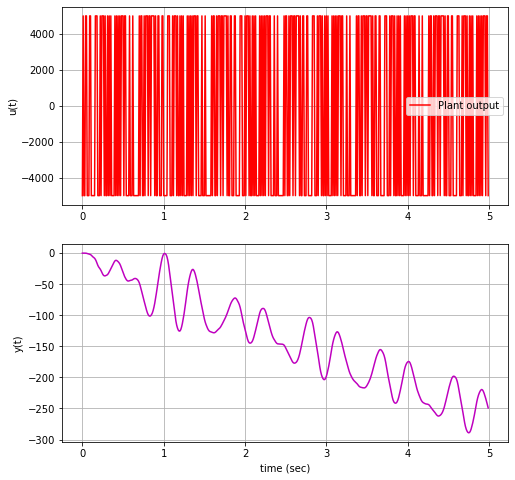

In [26]:
noise_level = 0.1
Ts = 0.01
t_sim = np.arange(0,5,Ts)
num_samples = t_sim.shape[0]
u_data = PRBS_generator(5000,num_samples) # generate PRBS with spedified amplitude
t_data, y_data = ctl.forced_response(P, t_sim, u_data)
ym_data = y_data + noise_level*np.random.rand(num_samples) # add noise to output
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
ax1.plot(t_data,u_data,'r-')
ax1.grid(True)
ax1.set_ylabel('u(t)')
ax1.legend(["PRBS input"])

ax2.plot(t_data,ym_data,'m-')
ax2.grid(True)
ax2.set_ylabel('y(t)')
ax2.set_xlabel('time (sec)')
ax1.legend(["Plant output"])

plt.show()    

Figure 8 PRBS input and plant output from simulation

This input/output data is ready for processing by the LSID algorithm as explained earlier. Suppose the goal is to obtain 
a 7th order model in discrete-time  

$$
P(z) = \frac{b_1z^6 + b_2z^5 + b_3z^4 + b_4z^3 + b_5z^2 + b_6z+b_7}{z^7 + a_1z^6+a_2z^5+a_3z^4+a_4z^3+a_5z^2+a_6z+a_7} \tag{7}
$$
with coefficient vector
$$
\theta = [a_1, a_2, \ldots, a_7, b_1, b_2, \ldots, b_7]^T \tag{8}
$$

Construct the $X$ in (4) and the $Y$ vector 

In [34]:
Y = ym_data[7:490]
X = np.zeros((483,14))
for j in range(482):
    	X[j,:] = np.array([ -y_data[j+6], -y_data[j+5], -y_data[j+4], -y_data[j+3], -y_data[j+2], -y_data[j+1], -y_data[j], u_data[j+6], u_data[j+5], u_data[j+4], u_data[j+3], u_data[j+2], u_data[j+1], u_data[j]])

resulting in $X$ and $Y$ of size $483 \times 14$ and $483 \times 1$, respectively. The coefficient vector (8) is then 
computed by (5), or more conveniently using np.linalg.pinv()

In [38]:
theta_LS = np.linalg.pinv(X)@Y
theta_LS

array([-2.40054137e+00,  1.53920199e+00,  5.92026571e-01, -1.07939133e+00,
       -3.57534882e-01,  1.38794676e+00, -6.81414517e-01,  2.09780056e-06,
        1.59797292e-05,  3.17160190e-05,  2.90632423e-05,  1.28830774e-05,
        2.31240862e-06, -6.63009383e-07])

Both the numerator and denominator coefficients are contained in θ_LS. For further manipulation, 
we extract them to 2 separate vectors

In [47]:
a_n = theta_LS[:7]
b_n = theta_LS[7:14]

With these coefficient data, numerator and denominator polynomials are constructed and combined to a discrete-time 
transfer function 

In [63]:
z = ctl.tf("z")
numz = b_n[0]*z**6 + b_n[1]*z**5 + b_n[2]*z**4 + b_n[3]*z**3 + b_n[4]*z**2 + b_n[5]*z + b_n[6]
denz = z**7 + a_n[0]*z**6 + a_n[1]*z**5 + a_n[2]*z**4 + a_n[3]*z**3 + a_n[4]*z**2 + a_n[5]*z + a_n[6]
Pz_lsid = numz/denz
Pz_lsid

TransferFunction(array([ 2.09780056e-06,  1.59797292e-05,  3.17160190e-05,  2.90632423e-05,
        1.28830774e-05,  2.31240862e-06, -6.63009383e-07]), array([ 1.        , -2.40054137,  1.53920199,  0.59202657, -1.07939133,
       -0.35753488,  1.38794676, -0.68141452]), True)

The next step is to convert this discrete-time transfer function to continuous-time, in order to compare to the real 
plant, and to use it as a model for controller design (which is commonly done in continuous-time domain). We can write our 
own code to do the job.

**Note:** There could be some other method such as using symbolic package. 

From module 7 of Control Engineering Basic series, we learn the 3 approximation methods that can be used to transform 
between continuous and discrete-time domain. Note that in this case, the backward difference is less preferred in 
converting from discrete to continuous time, since a stable pole in discrete time can be mapped to unstable pole 
in continuous time by backward difference method. In this example, we use bilinear transformation, with its 
relationship between complex $s$ and $z$ described by

$$
s = \frac{2(z-1)}{T(z+1)} \tag{9}
$$

which can be manipulated to get $z$ as a function of $s$

$$
z = \frac{-(sT+2)}{(sT-2)} \tag{10}
$$

Define

$$
f(s) = -(sT+2) \tag{11}
$$

$$
g(s) = sT-2 \tag{12}
$$

So, (10) can be writtern as

$$
z = \frac{f(s)}{g(s)} \tag{13}
$$

It is left to the reader to show that , by substituting $z$ from (13) into (7) and rearranging terms, we have

$$
P(s) = \frac{b_1f^6g + b_2f^5g^2 + b_3f^4g^3+b_4f^3g^4+b_5f^2g^5+b_6fg^6+b_7g^7}{f^7+a_1f^6g+a_2f^5g^2+a_3f^4g^3+a_4f^3g^4+a_5f^2g^5+a_6fg^6+a_7g^7} \tag{14}
$$

with $f(s)$ and $g(s)$ written as $f$ and $g$ to simply the notation. The whole conversion process can then be 
computed by the following code


In [73]:
fz = -(s*Ts+2)
gz = (s*Ts-2)

nj=6
nums_id = b_n[nj]*gz**(nj+1)
dens_id = fz**(nj+1) + a_n[nj]*gz**(nj+1)

for j in range(nj):
    nums_id = nums_id + b_n[j]*(fz**(nj-j))*(gz**(j+1))
    dens_id = dens_id + a_n[j]*(fz**(nj-j))*(gz**(j+1))


Note that the code is applicable to a transfer function of any order by setting nj accordingly. After the numerator and 
denominator polynomials are obtained, construct the continuous-time transfer function from LSID process as

In [74]:
P_id = nums_id/dens_id
P_id

TransferFunction(array([-1.32149258e-20,  1.76590666e-18, -1.07638606e-14,  5.78609828e-13,
        2.09488186e-11,  4.08660135e-07, -9.92688486e-06, -1.19538263e-02]), array([-5.69522162e-14, -2.26508751e-11, -3.05268354e-08, -7.07442810e-07,
       -4.06546070e-04, -7.06255994e-04, -1.21017287e-01, -3.75321830e-02]))

Use bodeplot() to compare the frequency responses between this LSID model (G2) and the original plant (G1) as shown 
in Figure 9. Adjust the noise level using slider to see how the two curves match.

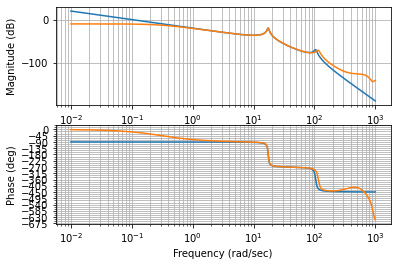

In [75]:
_,_,_ = ctl.bode_plot([P, P_id],dB=True, omega_limits=(0.01,1000))

Figure 9 Bode plot comparison between real plant and LSID model

The pole and zero locations of the real and LSID plant are shown in Figure 10 and 11, respectively.

(array([-4.52416794+104.88967916j, -4.52416794-104.88967916j,
        -0.4891654  +17.38377777j, -0.4891654  -17.38377777j,
         0.          +0.j        ]),
 array([], dtype=float64))

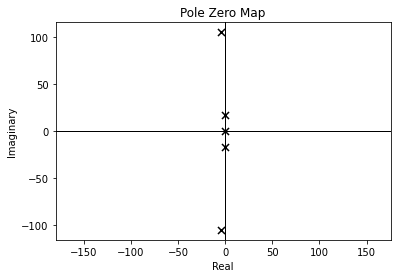

In [76]:
ctl.pzmap(P)

Figure 10 pole/zero mapping of real plant

(array([-191.98391056+692.88196065j, -191.98391056-692.88196065j,
          -6.24227893+115.86814761j,   -6.24227893-115.86814761j,
          -0.47710209 +17.45290942j,   -0.47710209 -17.45290942j,
          -0.31060143  +0.j        ]),
 array([  63.05555041+904.86496494j,   63.05555041-904.86496494j,
        -168.67417305+307.34237623j, -168.67417305-307.34237623j,
         295.97727774  +0.j        ,  200.          +0.j        ,
        -151.11032573  +0.j        ]))

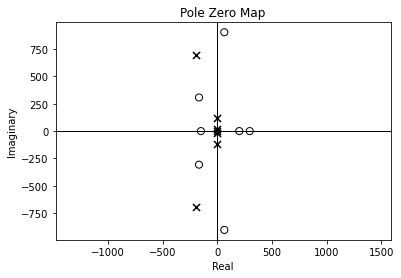

In [77]:
ctl.pzmap(P_id)

Figure 10 pole/zero mapping of LSID model

The results show that LSID model is able to capture dominant dynamics, which are the two lightly-damped modes. 
When the noise level is not present, it seems to match the low-frequency region well. Discrepancy becomes significant 
when noise level is raised. Also, the LSID transfer function has non-minimum phase zeros even though the real plant
has none. This explains the phase drop in the high frequency region.   


### Reference

1. L Ljung. System Identification: Theory for the User. 2nd ed. Prentice-Hall, 1999.

**Last Updated :** October 23,21 


<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>